## Units for the MEANGB\* keywords

The MEANGB\* keywords are in units of Gauss/pixel, not Gauss/Mm. To convert from Gauss/pixel to Gauss/Mm, multiply the values of MEANGB\* by a constant factor of 2.74.

This notebook describes the problem and derives the solution for converting these keys from Gauss/pixel to Gauss/Mm. 

In [1]:
import sunpy.map
import scipy.ndimage
import numpy as np
import math
import drms
from datetime import datetime as dt_obj
import matplotlib.pylab as plt

In [2]:
# define some constants
radsindeg = np.pi/180.
munaught  = 0.0000012566370614

To query the SHARP data, register your e-mail address with [JSOC](http://jsoc.stanford.edu/ajax/register_email.html).

In [3]:
email = 'your@email.address'
c = drms.Client(debug=True, verbose=True, email=email)

http://jsoc.stanford.edu/cgi-bin/ajax/checkAddress.sh?address=mbobra%2540stanford.edu&checkonly=1


The MEANGB\* keywords store the value of the derivative of the horizontal field (MEANGBH), vertical field (MEANGBZ), line-of-sight field (MEANGBL), and total field (MEANGBT). 

The formula to calculate the deriviative is $\sqrt{\left(\frac{dB}{dx}\right)^2 + \left(\frac{dB}{dy}\right)^2}$.

The units of the magnetic field, or dB, are in Gauss. The units of length, i.e. dx or dy, are in pixels. Therefore the units of dB/dx or dB/dy in Gauss/pixel. The keys MEANGB\* in the series hmi.sharp_720s and hmi.sharp_cea_720s are in Gauss/pixel.

To convert from Gauss/pixel to Gauss/Mm, multiply the value of MEANGB\* by a factor of (Gauss/pix)(pix/arcsec)(arsec/meter)(meter/Mm), which results in Gauss/Mm. Practically, this means multiplying the value of MEANGB\* by the following factor: (1/cdelt1_arcsec)(RSUN_OBS/RSUN_REF)(1000000), where 1/cdelt1_arcsec is the angle subtended on the Sun in arcseconds as observed by the spacecraft (see [here](https://github.com/mbobra/SHARPs/blob/master/cdelt1_arcsec.pdf) for a derivation of 1/cdelt1_arcsec). This value of this factor is 2.74.

First, we will look at a specific example for HARPNUM 86 at 2010.07.14_12:24:00 TAI.

In [4]:
# Identify a record
t_rec = '2010.07.14_12:24:00_TAI'
harpnum = '86'

In [5]:
# Query the data
hmi_query_string    = 'hmi.sharp_cea_720s['+harpnum+']['+t_rec+'][? (QUALITY<65536) ?]'
keyhmi             = c.query(hmi_query_string, key=drms.const.all)

http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=hmi.sharp_cea_720s%5B86%5D%5B2010.07.14_12%3A24%3A00_TAI%5D%5B%3F+%28QUALITY%3C65536%29+%3F%5D&key=%2A%2AALL%2A%2A
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=series_struct&ds=hmi.sharp_cea_720s


In [6]:
# Calculate cdelt_1 arcsec using the keyword metadata from this record
cdelt1_arcsec = (math.atan((keyhmi['RSUN_REF'][0]*keyhmi['CDELT1'][0]*radsindeg)/(keyhmi['DSUN_OBS'][0])))*(1/radsindeg)*(3600.)
cdelt1_arcsec

0.49428262675999274

In [7]:
# Calculate the factor using the keyword metadata from this record
factor = (1/cdelt1_arcsec)*(keyhmi['RSUN_OBS'][0]/keyhmi['RSUN_REF'][0])*(1000000)

In [8]:
print("For this record, we need to multiply the values of MEANGB* by a factor of",factor,".")

For this record, we need to multiply the values of MEANGB* by a factor of 2.7440606028364725 .


While this factor includes variable keywords, the variability cancels out to create a constant factor. The rest of this notebook will show why this factor is a constant.

Calculating this factor depends on the value of four keywords in the hmi.sharp_cea_720s series:
* `RSUN_REF`, a constant keyword that describes the reference radius of the Sun. The value of `RSUN_REF` is always 696,000,000.0 m.
* `CDELT1`, a constant keyword that describes the map scale in the X direction (`CDELT2` describes the map scale in the Y direction, and both have the same value). The value of `CDELT1` is always 0.03 degrees for data in the hmi.sharp_cea_720s series.
* `RSUN_OBS`, a variable keyword that describes the angular radius of the Sun in arcseconds.
* `DSUN_OBS`, a variable keyword that describes the distance from SDO to the center of the Sun in meters.

Now we will look at the maximum and minimum values of `RSUN_OBS` and `DSUN_OBS` and how they change over time.

In [9]:
hmi_query_string    = 'hmi.sharp_cea_720s[][2019.01.01/800d@7h]'
keyshmi             = c.query(hmi_query_string, key='T_REC,CDELT1,RSUN_OBS,DSUN_OBS,MEANGBL')

http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=rs_list&ds=hmi.sharp_cea_720s%5B%5D%5B2019.01.01%2F800d%407h%5D&key=T_REC%2CCDELT1%2CRSUN_OBS%2CDSUN_OBS%2CMEANGBL


In [10]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

In [11]:
t_rec_hmi = np.array([parse_tai_string(keyshmi.T_REC[i],datetime=True) for i in range(len(keyshmi.T_REC))])

Plot variation in RSUN_OBS over time (this is not smooth because it is overplotting many HARPs; otherwise it would be totally smooth).

Text(0.5, 1.0, 'Angular Radius of the Sun over time as observed by SDO')

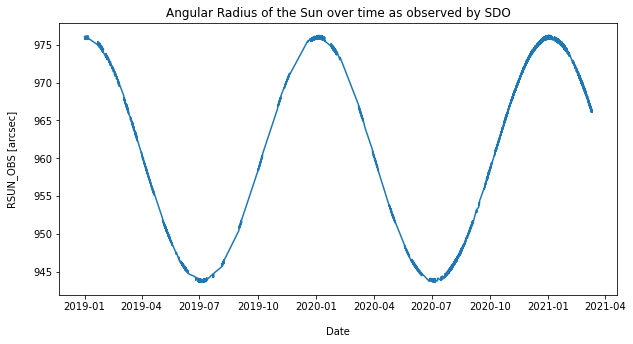

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t_rec_hmi,keyshmi['RSUN_OBS'])
ax.set_xlabel('Date')
ax.set_ylabel('RSUN_OBS [arcsec]')
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.set_title("Angular Radius of the Sun over time as observed by SDO")

In [13]:
print("The keyword RSUN_OBS varies by",(np.nanmax(keyshmi['RSUN_OBS'])-np.nanmin(keyshmi['RSUN_OBS']))/np.nanmax(keyshmi['RSUN_OBS'])*100,"percent.")

The keyword RSUN_OBS varies by 3.3429064757143063 percent.


Plot variation in DSUN_OBS over time.

Text(0.5, 1.0, 'Distance from SDO to Sun')

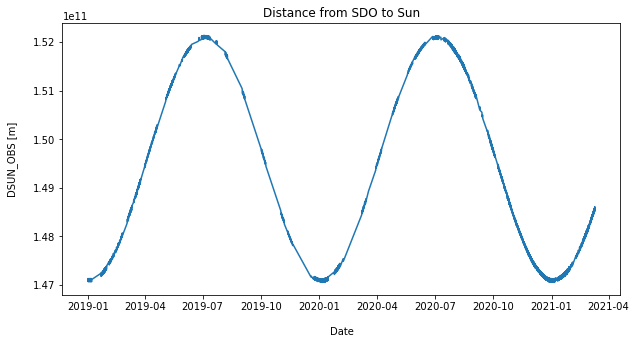

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t_rec_hmi,keyshmi['DSUN_OBS'])
ax.set_xlabel('Date')
ax.set_ylabel('DSUN_OBS [m]')
ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.set_title("Distance from SDO to Sun")

In [15]:
print("The keyword RSUN_OBS varies by",(np.nanmax(keyshmi['DSUN_OBS'])-np.nanmin(keyshmi['DSUN_OBS']))/np.nanmax(keyshmi['DSUN_OBS'])*100,"percent.")

The keyword RSUN_OBS varies by 3.342880394955568 percent.


RSUN_OBS and DSUN_OBS vary inversely; that is, when DSUN_OBS is at its maximum value, RSUN_OBS is at its minimum value. So we will evaluate how much value of MEANGB\* varies between two cases:

1. When DSUN_OBS is at maximum and RSUN_OBS is at minimum, and 
2. When DSUN_OBS is at minimum and RSUN_OBS is at maximum.

In [16]:
# Grab data for when DSUN_OBS is at maximum and RSUN_OBS is at minimum
dsun_obs_max = np.nanmax(keyshmi['DSUN_OBS'])
rsun_obs_min = np.nanmin(keyshmi['RSUN_OBS'])
cdelt1 = 0.03
rsun_ref = 696000000.

# Grab data for when DSUN_OBS is at minimum and RSUN_OBS is at maximum
dsun_obs_min = np.nanmin(keyshmi['DSUN_OBS'])
rsun_obs_max = np.nanmax(keyshmi['RSUN_OBS'])
cdelt1 = 0.03
rsun_ref = 696000000.

Find the value of the factor for Case 1: when DSUN_OBS is at maximum and RSUN_OBS is at minimum.

In [17]:
cdelt1_arcsec_case1 = (math.atan((rsun_ref*cdelt1*radsindeg)/(dsun_obs_max)))*(1/radsindeg)*(3600.)
factor_case1 = (1/cdelt1_arcsec_case1)*(rsun_obs_min/rsun_ref)*(1000000)
print(factor_case1)

2.7440603945984874


Find the value of the factor for Case 2: when DSUN_OBS is at minimum and RSUN_OBS is at maximum.

In [18]:
cdelt1_arcsec_case2 = (math.atan((rsun_ref*cdelt1*radsindeg)/(dsun_obs_min)))*(1/radsindeg)*(3600.)
factor_case2 = (1/cdelt1_arcsec_case2)*(rsun_obs_max/rsun_ref)*(1000000)
print(factor_case2)

2.744061135022291
